# Trabalho 02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import sys
import os 
sys.path.insert(0, os.path.abspath('../packages'))
import steps, functions, optimizers, constraints, constropt

In [3]:
step = steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True)

In [4]:
tol_osr = 1e-7
optimizrs = [
    ('Univariant', optimizers.UnivariantOptimizer(tol=tol_osr)),
    ('Powell', optimizers.PowellOptimizer(tol=tol_osr)),
    ('Steepest', optimizers.SteepestDescentOptimizer(tol=tol_osr)),
    ('FletchRvs', optimizers.FletcherReevesOptimizer(tol=tol_osr)),
    ('NewtnRaph', optimizers.NewtonRaphsonOptimizer(tol=tol_osr)),
    ('BFGS', optimizers.BFGSOptimizer(tol=tol_osr)),
]

In [5]:
constrained_optimizer = constropt.ConstrainedOptimizer(tol=1e-6)

## Questão 01

### Função a minimizar

In [10]:
def f(x1, x2):

    return (x1 - 2)**4 + (x1-2*x2)**2

def gradf(x1, x2):

    return np.array(
        [ 4.0*(x1 - 2.0)**3.0 + 2.0*(x1-2.0*x2), 
        -4.0*(x1-2.0*x2)]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 12.0*(x1-x2)**2 + 2.0, -4.0],
        [-4.0,  8.0]
        ]
    )

f = functions.AnalyticalSpecialFunction(f, gradf, hessf)


### Restrição

In [7]:
cfs = []

def cf(x1, x2):

    return x1**2 - x2

def gradf(x1, x2):

    return np.array(
        [ 2.0*x1, 
        -1.0]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 2.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

In [8]:
cases = [
    ('Penalidade', np.array([3,2]), [constraints.PenaltyInequityConstraint(cf, r0=1.0, beta=10.0) for cf in cfs], 'r'),
    ('Barreira'  , np.array([0,1]), [constraints.BarrierInequityConstraint(cf, r0=10.0, beta=0.1) for cf in cfs], 'b')
]

Univariant: p_final = [0.942897, 0.889055, 1.946311].T. Execução:0:00:00.632754, 8 iterações
Univariant: p_final = [0.947489, 0.897736, 1.946249].T. Execução:0:00:21.075811, 15 iterações
Powell: p_final = [0.945580, 0.894121, 1.946183].T. Execução:0:00:00.471134, 8 iterações
Powell: p_final = [0.945585, 0.894132, 1.946184].T. Execução:0:00:29.293983, 15 iterações
Steepest: p_final = [0.945543, 0.894051, 1.946183].T. Execução:0:00:00.647455, 8 iterações
Steepest: p_final = [0.945636, 0.894228, 1.946184].T. Execução:0:02:18.919840, 15 iterações
FletchRvs: p_final = [0.945584, 0.894129, 1.946183].T. Execução:0:00:00.627073, 8 iterações
FletchRvs: p_final = [0.945592, 0.894144, 1.946184].T. Execução:0:02:08.177761, 15 iterações
NewtnRaph: p_final = [0.945386, 0.893754, 1.946183].T. Execução:0:00:00.740869, 8 iterações
NewtnRaph: p_final = [0.955936, 0.913813, 1.948098].T. Execução:0:00:28.204821, 15 iterações
BFGS: p_final = [0.945583, 0.894127, 1.946183].T. Execução:0:00:00.666571, 8 iter

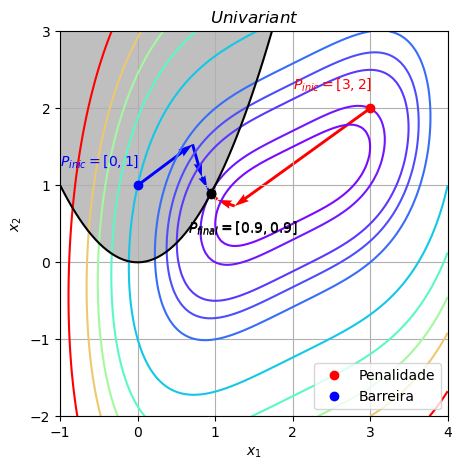

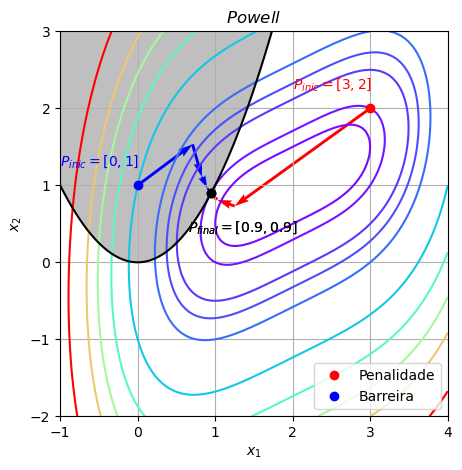

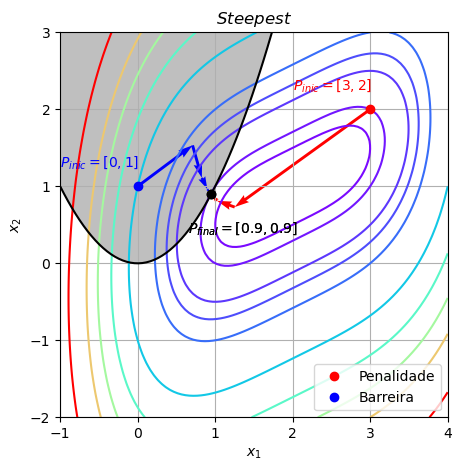

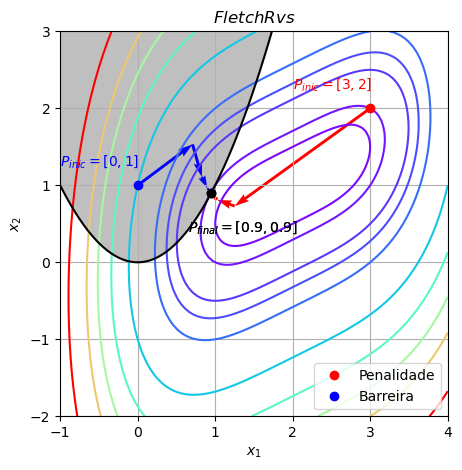

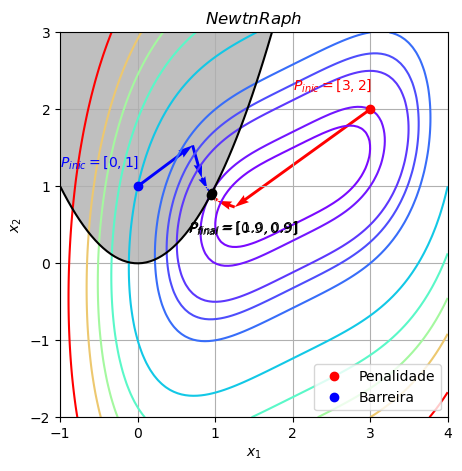

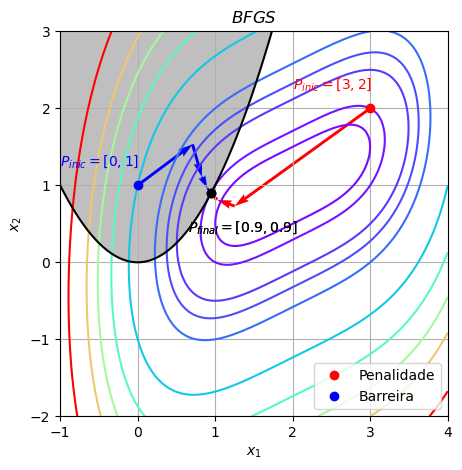

In [11]:
item = '1'

x = np.linspace(-1, 4, 100)
y = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
levels =[0, 1, 2, 5, 7, 10, 20, 30, 40, 50, 70]
#levels = np.linspace(0,120, 10)
cZs = [cf(X, Y) for cf in cfs]

for name, optimizer in optimizrs:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.contour(X, Y, Z, levels ,cmap='rainbow')
    for cZ in cZs:
        ax.contour(X, Y, cZ, [0],cmap='gray')
        ax.contourf(X, Y, cZ, [-100000, 0],cmap='gray', alpha=0.5)
    for case_name, p_inicial, constrs, color in cases:
        t_init = datetime.datetime.now()
        f_otim = constraints.ConstrainedSpecialFunction(f, cfuncs=constrs)
        p_final = constrained_optimizer(f_otim, p_inicial, optimizer, step)
        t_final = datetime.datetime.now()
        print(f'{name}: p_final = [{p_final[0]:.6f}, {p_final[1]:.6f}, {f(*p_final):.6f}].T. Execução:{t_final - t_init}, {constrained_optimizer.iter} iterações')
        ax.plot(*p_inicial, f'{color}o',label=case_name)
        ax.text(p_inicial[0]-1.0, p_inicial[1]+0.25, f'$P_{{inic}} = [{p_inicial[0]}, {p_inicial[1]}]$', color=color)
        ax.plot(*p_final, 'ko')
        ax.text(p_final[0]-0.3, p_final[1]-0.5, f'$P_{{final}} = [{p_final[0]:.1f}, {p_final[1]:.1f}]$', color='k')
        cache = constrained_optimizer.cache_x
        for i in range(len(cache)-1):
            p_i = cache[i]
            p_f = cache[i+1]
            ax.quiver(p_i[0], p_i[1], p_f[0]-p_i[0], p_f[1]-p_i[1], color=color, angles='xy', scale_units='xy', scale=1)#, label='Passo completo')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'${name}$')
    fig.savefig(f'images/q{item}_{name}.pdf')

## Questão 02

## Questão 03

### Função a minimizar

In [13]:
def f(x1, x2):

    return (x1 - 10)**3 + (x2 - 20)**3

def gradf(x1, x2):

    return np.array(
        [ 3.0*(x1 - 10) ** 2, 
          3.0*(x2 - 20) ** 2]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 6.0*(x1 - 10), 0.0],
        [ 0.0,  6.0*(x1 - 20)]
        ]
    )

f = functions.AnalyticalSpecialFunction(f, gradf, hessf)


### Restrições

In [14]:
cfs = []

# 100.0 - (x1 - 5.0)**2 - (x2 - 5.0)**2 <= 0
def cf(x1, x2):

    return 100.0 - (x1 - 5.0)**2 - (x2 - 5.0)**2

def gradf(x1, x2):

    return np.array(
        [ -2.0*(x1 - 5), 
          -2.0*(x2 - 5)]
    )

def hessf(x1, x2):

    return np.array(
        [
        [-2.0, 0.0],
        [ 0.0,-2.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

# -82.81 + (x1 - 6.0)**2 + (x2 - 5.0)**2 <= 0
def cf(x1, x2):

    return -82.81 + (x1 - 6.0)**2 + (x2 - 5.0)**2

def gradf(x1, x2):

    return np.array(
        [ 2.0*(x1 - 6), 
          2.0*(x2 - 5)]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 2.0, 0.0],
        [ 0.0, 2.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

In [15]:
cases = [
    ('Penalidade', np.array([14, 6]), [constraints.PenaltyInequityConstraint(cf, r0=1.0, beta=10.0) for cf in cfs], 'r'),
    ('Barreira'  , np.array([30,20]), [constraints.BarrierInequityConstraint(cf, r0=10.0, beta=0.1) for cf in cfs], 'b')
]

In [17]:
item = '2'

x = np.linspace(0, 30, 100)
y = np.linspace(0, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
#levels =[0, 1, 2, 5, 7, 10, 20, 30, 40, 50, 70]
levels = np.linspace(0,7000, 20)
cZs = [cf(X, Y) for cf in cfs]

for name, optimizer in optimizrs:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.contour(X, Y, Z, levels ,cmap='rainbow')
    for cZ in cZs:
        ax.contour(X, Y, cZ, [0],cmap='gray')
        ax.contourf(X, Y, cZ, [-100000, 0],cmap='gray', alpha=0.5)
    for case_name, p_inicial, constrs, color in cases:
        t_init = datetime.datetime.now()
        f_otim = constraints.ConstrainedSpecialFunction(f, cfuncs=constrs)
        p_final = constrained_optimizer(f_otim, p_inicial, optimizer, step)
        t_final = datetime.datetime.now()
        print(f'{name}: p_final = [{p_final[0]:.6f}, {p_final[1]:.6f}, {f(*p_final):.6f}].T. Execução:{t_final - t_init}, {constrained_optimizer.iter} iterações')
        ax.plot(*p_inicial, f'{color}o',label=case_name)
        ax.text(p_inicial[0]-1.0, p_inicial[1]+0.25, f'$P_{{inic}} = [{p_inicial[0]}, {p_inicial[1]}]$', color=color)
        ax.plot(*p_final, 'ko')
        ax.text(p_final[0]-0.3, p_final[1]-0.5, f'$P_{{final}} = [{p_final[0]:.1f}, {p_final[1]:.1f}]$', color='k')
        cache = constrained_optimizer.cache_x
        for i in range(len(cache)-1):
            p_i = cache[i]
            p_f = cache[i+1]
            ax.quiver(p_i[0], p_i[1], p_f[0]-p_i[0], p_f[1]-p_i[1], color=color, angles='xy', scale_units='xy', scale=1)#, label='Passo completo')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'${name}$')
    fig.savefig(f'images/q{item}_{name}.pdf')